In [1]:
import toml 
import pylab as pl 
import litebird_sim as lbs 

TOAST INFO: mpi4py not found- using serial operations only


In [3]:
hwdic = toml.load ('/Users/peppe/work/satellite_sims/hardware/MFT_subset.toml')

# 1. Construct the bandpasses and build the sampler 

We loop over the several kind of band shape  available in `BandPassInfo`

M1-140 {'center': 140.0, 'bandwidth': 42, 'bandpass': '', 'NET': 59.29, 'fwhm': 30.8, 'fknee': 20.0, 'fmin': 0.01, 'alpha': 1}
Can't resample if no sampler is built and/or provided, interpolating the band


/Users/peppe/Library/Mobile Documents/com~apple~CloudDocs/icloud_work/lb_bpass/litebird_sim/litebird_sim/bandpasses.py:232: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]
/Users/peppe/Library/Mobile Documents/com~apple~CloudDocs/icloud_work/lb_bpass/litebird_sim/litebird_sim/bandpasses.py:232: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


Can't resample if no sampler is built and/or provided, interpolating the band


Can't resample if no sampler is built and/or provided, interpolating the band
Can't resample if no sampler is built and/or provided, interpolating the band


M2-166 {'center': 166.0, 'bandwidth': 50, 'bandpass': '', 'NET': 56.79, 'fwhm': 28.9, 'fknee': 20.0, 'fmin': 0.01, 'alpha': 1}
M1-195 {'center': 195.0, 'bandwidth': 59, 'bandpass': '', 'NET': 60.2, 'fwhm': 28.0, 'fknee': 20.0, 'fmin': 0.01, 'alpha': 1}
Can't resample if no sampler is built and/or provided, interpolating the band


Can't resample if no sampler is built and/or provided, interpolating the band


Can't resample if no sampler is built and/or provided, interpolating the band
Can't resample if no sampler is built and/or provided, interpolating the band


M1-100 {'center': 100.0, 'bandwidth': 20, 'bandpass': '', 'NET': 81.77, 'fwhm': 37.8, 'fknee': 20.0, 'fmin': 0.01, 'alpha': 1}
Can't resample if no sampler is built and/or provided, interpolating the band


Can't resample if no sampler is built and/or provided, interpolating the band


Can't resample if no sampler is built and/or provided, interpolating the band
Can't resample if no sampler is built and/or provided, interpolating the band
M2-119 {'center': 119.0, 'bandwidth': 36, 'bandpass': '', 'NET': 62.68, 'fwhm': 33.6, 'fknee': 20.0, 'fmin': 0.01, 'alpha': 1}


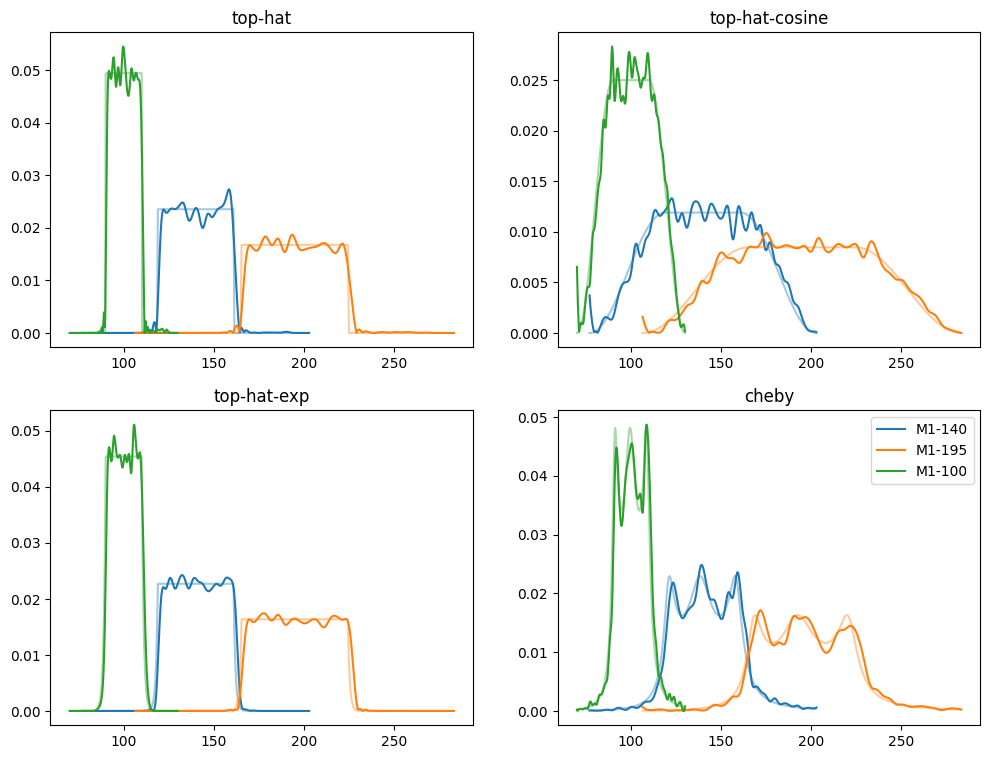

In [4]:
i=0 
pl.figure(figsize=(12,9))
samplerbands={} 
for bandname, band in hwdic['bands'].items()   : 
    print(bandname , band)
    if bandname[:2]!="M1": continue 
    samplerbands[bandname] = {}

    for j, btype in enumerate(['top-hat','top-hat-cosine','top-hat-exp','cheby']):
        Band = lbs.bandpasses.BandPassInfo( bandcenter_ghz=band['center'], 
                                        bandwidth_ghz=band['bandwidth'],
                                        bandtype=btype,
                                        normalize=True,
                                       nsamples_inband=256)#256
        sampled = Band.bandpass_resampling (nresample=50,bstrap_size=5000,) 
        samplerbands[bandname][btype] = Band
        pl.subplot(221+j)
        pl.title(btype )
        pl.plot(Band.freqs_ghz, Band.weights   , alpha=.4,color=f"C{i}" )
        pl.plot(Band.freqs_ghz, sampled,  color=f"C{i}", label=bandname )
    i+=1 
    #break 
pl.legend()

# 2. make per detector bpasses 
now we sample for each detector top-hat w/ an exponential cut off bandpasses. Notice that each detector will have the same centroid and bandwidth, but each band will look different, as they are different realizations of the same sampler. 


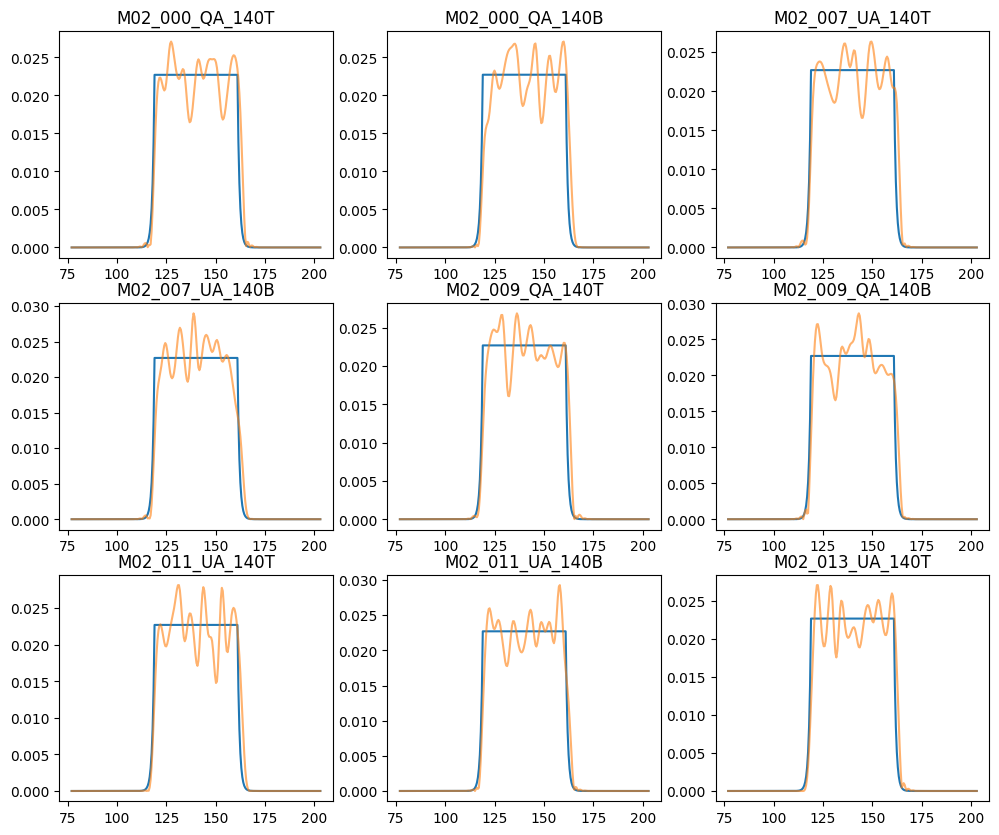

In [5]:
perdet_bands ={k:{}  for k in hwdic['bands'].keys() } 
btype ='top-hat-exp'
counter = 0 
pl.figure (figsize=(12,10))
for det, detdata  in hwdic['detectors'].items()   : 
    if detdata['band' ]!="M1-140":continue 
 
    
    B = samplerbands[detdata['band' ]][btype] 
    perdet_bands[detdata['band' ]] [det] =B.bandpass_resampling() 
    pl.subplot(3,3,1+counter)
    pl.title(det)
    pl.plot(B.freqs_ghz, B.weights   )

    pl.plot(B.freqs_ghz, perdet_bands [detdata['band' ]] [det]   , alpha=.6)
    
    counter+=1
    if counter==9: break 
    



# 3. Save Bpasses per freq. band as hdf5 file 

In [6]:
import h5py as h5 

for bandstring in [ "M1-140"]: 
#for bandstring in perdet_bands.keys() : 
    B = samplerbands[bandstring][btype]
    f = h5.File(f"{bandstring}.hdf5", "w")
    
    f.create_dataset("Band_freqs_ghz", B.freqs_ghz.shape, data=B.freqs_ghz )
    
    for det, bandweights  in perdet_bands[bandstring].items() :
        f.create_dataset(det , data=bandweights )

    f.close()

# 4.Read from  hdf5 file 

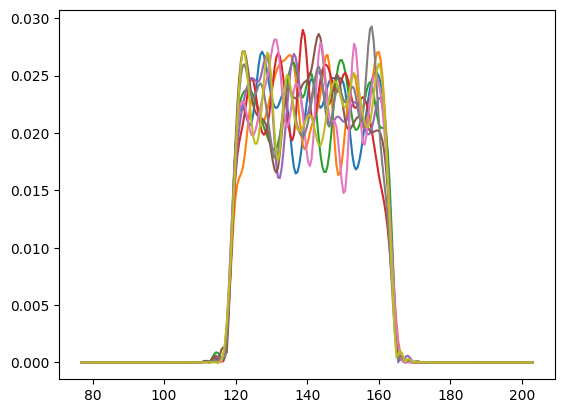

In [8]:
counter=0
for det, detdata  in hwdic['detectors'].items()   : 
    if detdata['band' ]!="M1-140":continue 
    f = h5.File(f"{detdata['band' ]}.hdf5", "r")
    
    freqs = f['Band_freqs_ghz'][...]
    weights  = f[det][...]
    f.close() 
    pl.plot(freqs, weights )
    counter+=1
    if counter==9: break 